In [1]:
import pandas as pd
import numpy as np
import sys, os
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
df = pd.read_csv("./dataset/new_bgg_data_after_eda2_new.csv",encoding="utf-8")
df.drop(columns = ["Rank", "Id", "Name", "Users_rated"], inplace = True)

In [3]:
df_ = df.copy()

### Data Engineering

In [4]:
# Year
df_v1 = df_.copy()
before = df_.shape[0]
df_v1.drop(index = df_v1[df_v1.Year < 1600].index, inplace=True)
after = df_v1.shape[0]
print (f"By year, we drop {before - after} entries.")


By year, we drop 202 entries.


In [5]:
# MaxPlayer
df_v2 = df_v1.copy() 
before = df_v1.shape[0]
df_v2.drop(index = df_v2[df_v2.Maxplayers > 10].index, inplace=True)
after = df_v2.shape[0]
print (f"By Max Player, we drop {before - after} entries.")

By Max Player, we drop 677 entries.


In [6]:
# drop artist
df_v3 = df_v2.copy() 
df_v3.drop(columns="Nartist", inplace=True)


In [7]:
# by designer
df_v4 = df_v3.copy() 
# before = df_v3.shape[0]
# df_v4.drop(index = df_v4[df_v4.Ndesign > 7].index, inplace=True)
# after = df_v4.shape[0]
# print (f"By Max Player, we drop {before - after} entries.")

df_v4.drop(columns="Ndesign", inplace=True)


### Dataset split into train, test (+ validation)

In [8]:
test_size = 0.2
random_state = 42

In [9]:
from sklearn.model_selection import train_test_split

def get_Xs_Ys(df, target, exclude, use_val=True):

      assert type(target) == list, "target must be list"
      assert type(exclude) == list, "exclude must be list"

      train, test = train_test_split(
                        df,
                        test_size = test_size,
                        random_state = random_state)
      if use_val:
            train, val = train_test_split(
                              train,
                              test_size = test_size,
                              random_state = random_state)


      get_y = lambda data : data[target]
      get_x = lambda data : data.drop(columns = target + exclude)

      Ys = {"train" : get_y(train),
            "test" : get_y(test)}
      Xs = {"train" : get_x(train),
            "test" : get_x(test)}
      
      if use_val:
            Ys['val'] = get_y(val)
            Xs['val'] = get_x(val)
            
      return Xs, Ys, target
        
Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"])

### Modeling for Problem 1

1. Baseline with mean

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def eval_models(y_pred, y_true, verbose = False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    if verbose:
        
        return {"MSE" : mse,
                "RMSE" : rmse,
                "MAE" : mae,
                "R2": r2}
    else:
        return mse, rmse, mae, r2

In [13]:

baseline_Rating = [Ys['train'].Rating.mean()]* Ys['test'].shape[0]
baseline_Complexity = [Ys['train'].Complexity.mean()]* Ys['test'].shape[0]

print(f"Rating : {round(baseline_Rating[0], 2)}, Complexity : {round(baseline_Complexity[0], 2)}")

pd.DataFrame([eval_models(baseline_Rating, Ys["test"].Rating, verbose=True), eval_models(baseline_Complexity, Ys["test"].Complexity, verbose=True)],
             index = ["Rating", "Complexity"])

Rating : 6.39, Complexity : 1.97


,MSE,RMSE,MAE,R2
Rating,0.856110,0.925262,0.717573,-0.000380
Complexity,0.700721,0.837091,0.675491,-0.000032


2. Simple Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline

In [15]:
def make_simple_linear(sk_args = {}, lrg_arg = {}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        LinearRegression(**lrg_arg),
    )

In [16]:


def result_regress(model, Xs, Ys, y_order):
    
    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns = Xs['train'].columns)
    x_val = pd.DataFrame(scaler.transform(Xs['val']), columns = Xs['val'].columns)
    x_test = pd.DataFrame(scaler.transform(Xs['test']), columns= Xs['test'].columns)
    
    model.fit(x_train, Ys['train'].iloc[:, y_order])
    
    y_pred_train = model.predict(x_train)
    y_pred_val   = model.predict(x_val)
    y_pred_test  = model.predict(x_test)
    
    eval_train = eval_models(y_pred_train, Ys['train'].iloc[:, y_order])
    eval_val = eval_models(y_pred_val, Ys['val'].iloc[:, y_order])
    eval_test = eval_models(y_pred_test, Ys['test'].iloc[:, y_order])


    return pd.DataFrame([eval_train, eval_val, eval_test], columns=["MSE", "RMSE", "MAE", "R2"], index = ["train", "validation", "test"]) 


In [22]:
target1 = result_regress(make_simple_linear(), Xs, Ys, 0)   # Rating


In [23]:
target2 = result_regress(make_simple_linear(), Xs, Ys, 1)   # Complexity

In [24]:
simple_test = pd.concat([target1.loc['test'], target2.loc['test']], axis=1).T
simple_test.index=["Rating", "Complexity"]
simple_test

,MSE,RMSE,MAE,R2
Rating,0.618930,0.786721,0.605074,0.276769
Complexity,0.347504,0.589494,0.453749,0.504061


In [25]:
make_simple_linear()

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000255EF87B040>)),
                ('linearregression', LinearRegression())])

In [26]:

from sklearn.model_selection import GridSearchCV

def find_best_k(df, results=False):
    params = {
        
        'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)
    
    grid_searchs = []

    for i in tqdm(range(len(target_list))):
        grid_search = GridSearchCV(make_simple_linear(), param_grid=params, scoring="r2", cv=5, verbose=1)
        grid_search.fit(x_train, Ys['train'].iloc[:, i])

        grid_searchs.append(grid_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", grid_search.best_params_)
        print("Best R2 Score: ", grid_search.best_score_)
    
    if results:
        return grid_searchs, scaler

In [27]:
find_best_k(df) # with no enginering

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.3683069909599011
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6013729930439119


In [28]:
find_best_k(df_v1) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.39085518008709574
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6061799210222591


In [29]:
find_best_k(df_v2) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.399593273228792
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.6143796386934313


In [56]:
linear_model, scaler_v3 = find_best_k(df_v3, results=True) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.4012746324669556
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6139958571737403


In [31]:
def test_eval(x_test, y_test, model, target_list, scaler = None):
    
    if scaler is not None:
        x_test = x_test.copy()
        x_test = scaler.transform(x_test)
        x_test = pd.DataFrame(x_test, columns = Xs['test'].columns)
    
    eval_tests = []
    for i in range(len(target_list)):

        eval_test = eval_models(model[i].predict(x_test), Ys['test'][target_list[i]])
        eval_tests.append(eval_test)

    return pd.DataFrame(eval_tests, index=target_list, columns=["MSE", "RMSE", "MAE", "R2"])

In [57]:
Xs, Ys, target_list = get_Xs_Ys(df_v3, ["Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

In [60]:
simple_linear_test_eval = test_eval(Xs['test'], Ys['test'], linear_model, target_list, scaler = scaler_v3)

In [61]:
simple_linear_test_eval

,MSE,RMSE,MAE,R2
Rating,0.509316,0.713664,0.536105,0.397431
Complexity,0.280267,0.529403,0.384349,0.594288


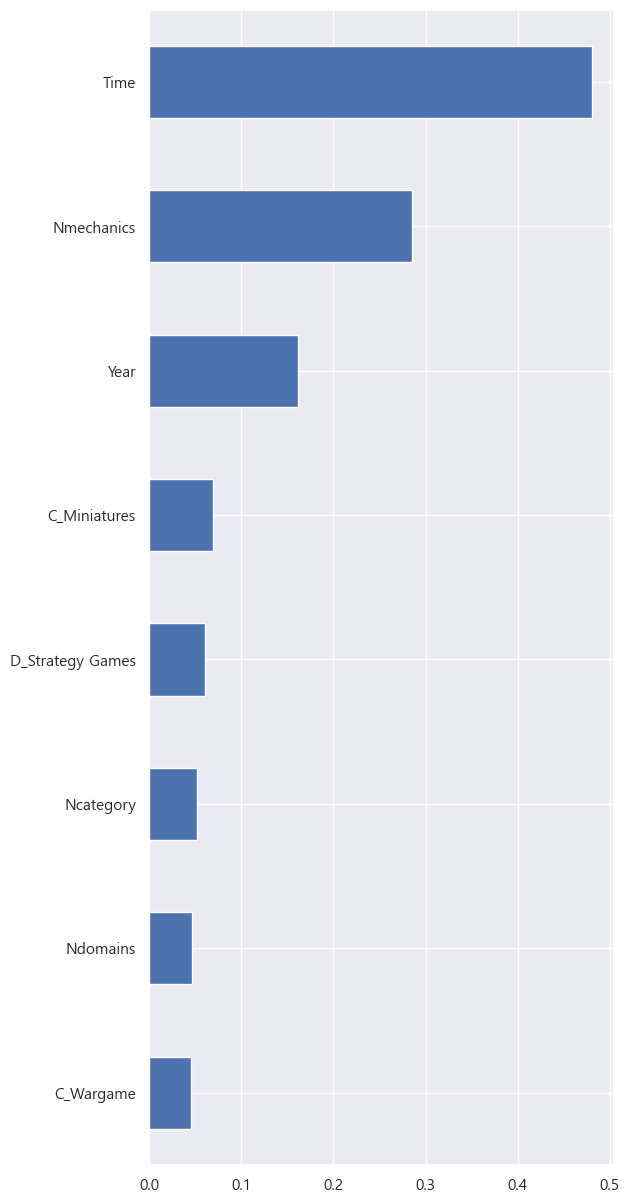

In [62]:
# check last model about Rating
plt.rcParams['font.family'] = 'Malgun Gothic'
coef_ = pd.Series(linear_model[0].best_estimator_['linearregression'].coef_,
                  index=linear_model[0].best_estimator_['selectkbest'].get_feature_names_out()).sort_values(ascending=False)
coef_[:8].sort_values().plot.barh(figsize=(6, 15))


plt.show()


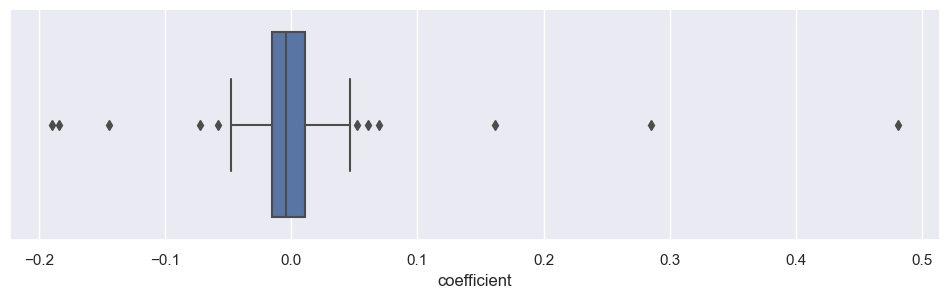

In [36]:
# 엄청나게 비대칭적인 계수 현황
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()


c:\Users\pokem\anaconda3\envs\project2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


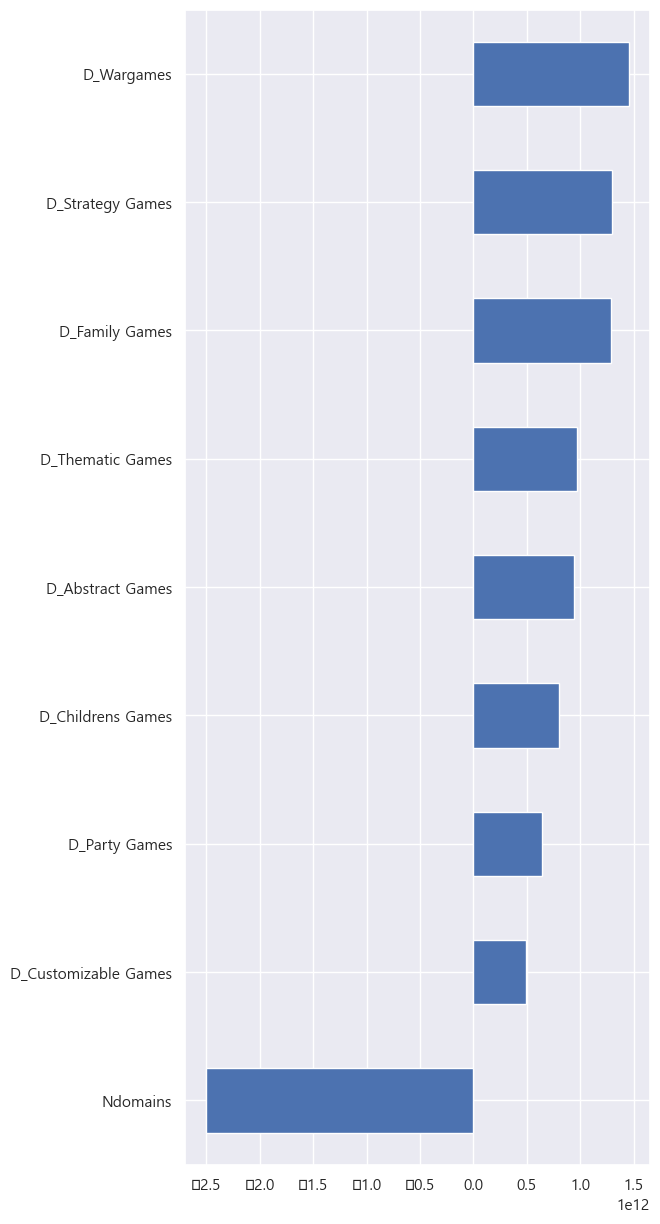

In [37]:
# check last model about Complexity
plt.rcParams['font.family'] = 'Malgun Gothic'
coef_ = pd.Series(linear_model[1].best_estimator_['linearregression'].coef_,
          index = linear_model[1].best_estimator_['selectkbest'].get_feature_names_out()).sort_values(ascending=False)
pd.concat([coef_.head(8), coef_.tail(1)]
          ).sort_values().plot.barh(figsize=(6, 15))


plt.show()

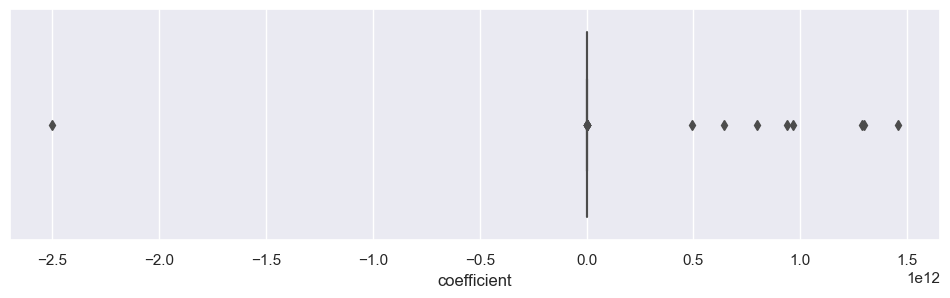

In [38]:
# 엄청나게 비대칭적인 계수 현황
sns.set(rc={'figure.figsize':(12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()

2. 1. regression with y = $\frac{C}{f(X)}$

In [39]:
# def find_best_k_inverse(df, c=1e+6, results=False):
#     params = {
        
#         'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        
#     }
#     Xs, Ys, target_list = get_Xs_Ys(df, ["Users_rated"], ["Sug_players", "Sug_age", "Language_dependence", "Own", "Rating", "Complexity"], use_val=False)

#     scaler = StandardScaler()
    
#     x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)
    
#     grid_searchs = []

#     for i in tqdm(range(len(target_list))):
#         grid_search = GridSearchCV(make_simple_linear(), param_grid=params, scoring="r2", cv=5, verbose=1)
#         grid_search.fit(x_train, c/Ys['train'].iloc[:, i])

#         grid_searchs.append(grid_search)
#         print(f"Target : {target_list[i]}")
#         print("Best parameter: ", grid_search.best_params_)
#         print("Best R2 Score: ", grid_search.best_score_)
    
#     if results:
#         return grid_searchs, scaler

In [40]:
# dataset = [df, df_v1, df_v2, df_v3, df_v4]

# for i, data in tqdm(enumerate(dataset)):
#     print(f"df_v[{i}] : " ,end="")
#     find_best_k_inverse(data, c=1e+5) # with no enginering


3. Linear Regression with Ridge Regularization

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

In [42]:
def make_ridge(sk_args= {}, rd_args = {}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        Ridge(**rd_args, random_state=random_state),
    )
make_ridge()

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000255EF87B040>)),
                ('ridge', Ridge(random_state=42))])

In [43]:
def find_best_param_randomly(df, results=False):
    params = {
        'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
        'ridge__alpha' : np.random.uniform(1e-4, 1e+5, 100)
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)

    random_searchs = []
    
    for i in tqdm(range(len(target_list))):
        random_search = RandomizedSearchCV(make_ridge(), params, n_iter = 100,
                                           n_jobs=-1, random_state=random_state, cv=5)
        random_search.fit(x_train, Ys['train'].iloc[:, i])
        
        random_searchs.append(random_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", random_search.best_params_)
        print("Best R2 Score: ", random_search.best_score_)
    
    if results:
        return random_searchs, scaler

In [44]:
find_best_param_randomly(df) # with no engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Target : Rating
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 2182.165829403185}
Best R2 Score:  0.36005159059663683
Target : Complexity
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 2182.165829403185}
Best R2 Score:  0.599537477338906


In [45]:
find_best_param_randomly(df_v1) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Target : Rating
Best parameter:  {'selectkbest__k': 150, 'ridge__alpha': 6563.233574157276}
Best R2 Score:  0.3741257055857045
Target : Complexity
Best parameter:  {'selectkbest__k': 150, 'ridge__alpha': 6563.233574157276}
Best R2 Score:  0.6006753000933823


In [46]:
ridge_model, scaler_v2 = find_best_param_randomly(df_v2, results=True) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Target : Rating
Best parameter:  {'selectkbest__k': 90, 'ridge__alpha': 148.40609503690183}
Best R2 Score:  0.38975749935513254
Target : Complexity
Best parameter:  {'selectkbest__k': 90, 'ridge__alpha': 148.40609503690183}
Best R2 Score:  0.6111310194099667


In [47]:
find_best_param_randomly(df_v3) # with engineering

  0%|          | 0/2 [00:00<?, ?it/s]

Target : Rating
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 2894.483162187449}
Best R2 Score:  0.38869537711236496
Target : Complexity
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 2894.483162187449}
Best R2 Score:  0.6126054961039344


In [48]:
Xs, Ys, target_list = get_Xs_Ys(df_v2, ["Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

In [49]:
ridge_test_eval = test_eval(Xs['test'], Ys['test'], ridge_model, target_list, scaler = scaler_v2)

In [50]:
ridge_test_eval

,MSE,RMSE,MAE,R2
Rating,0.516642,0.718778,0.540235,0.388763
Complexity,0.283878,0.532802,0.385599,0.589062


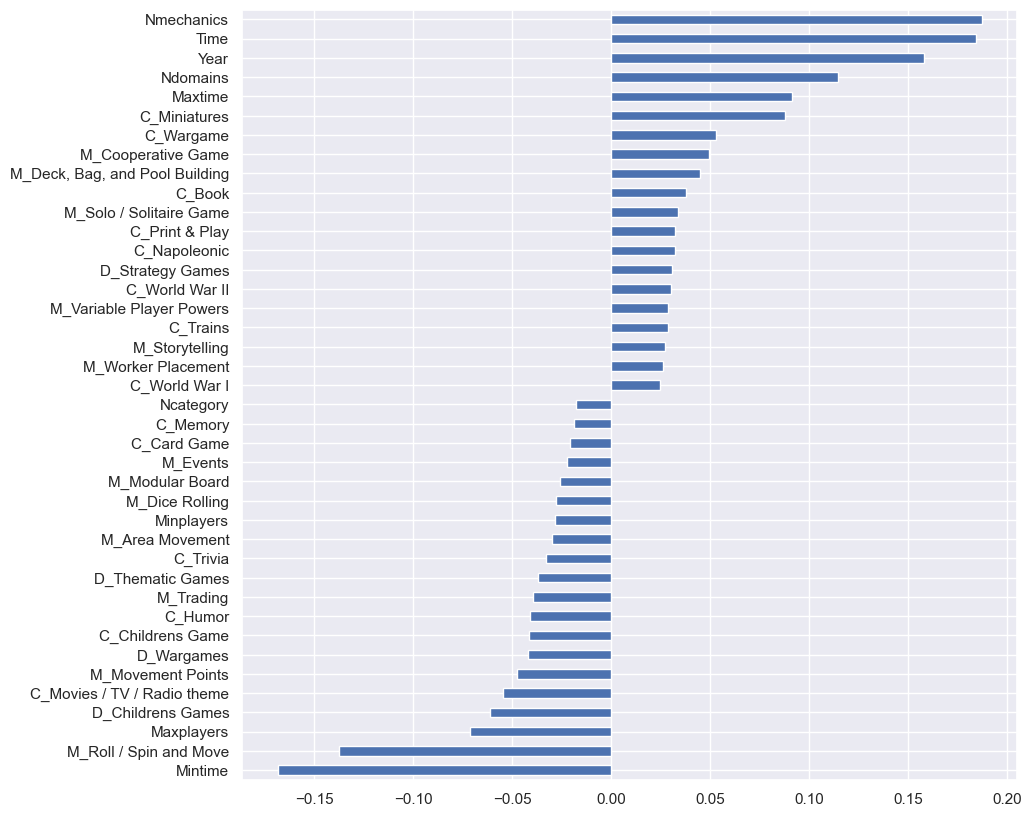

In [68]:
# check last model about Rating
matplotlib.rcParams['font.family'] = 'sans-serif'
coef_ = pd.Series(ridge_model[0].best_estimator_['ridge'].coef_,
                  index=ridge_model[0].best_estimator_['selectkbest'].get_feature_names_out()).sort_values()

pd.concat([coef_.head(20), coef_.tail(20)]).plot.barh(figsize=(10, 10))
plt.show()


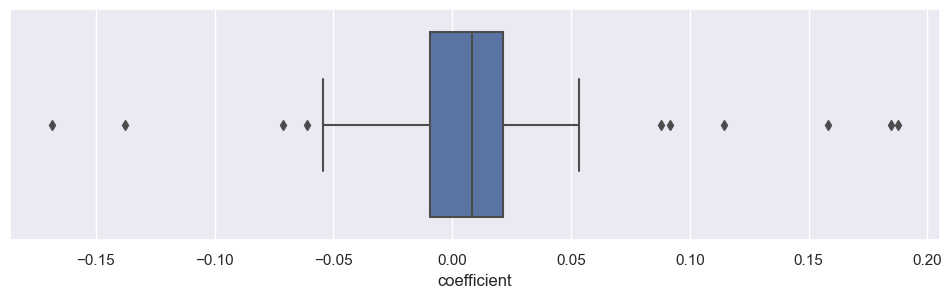

In [69]:
# simple linear에 비해 비교적 대칭적인 회귀계수
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()


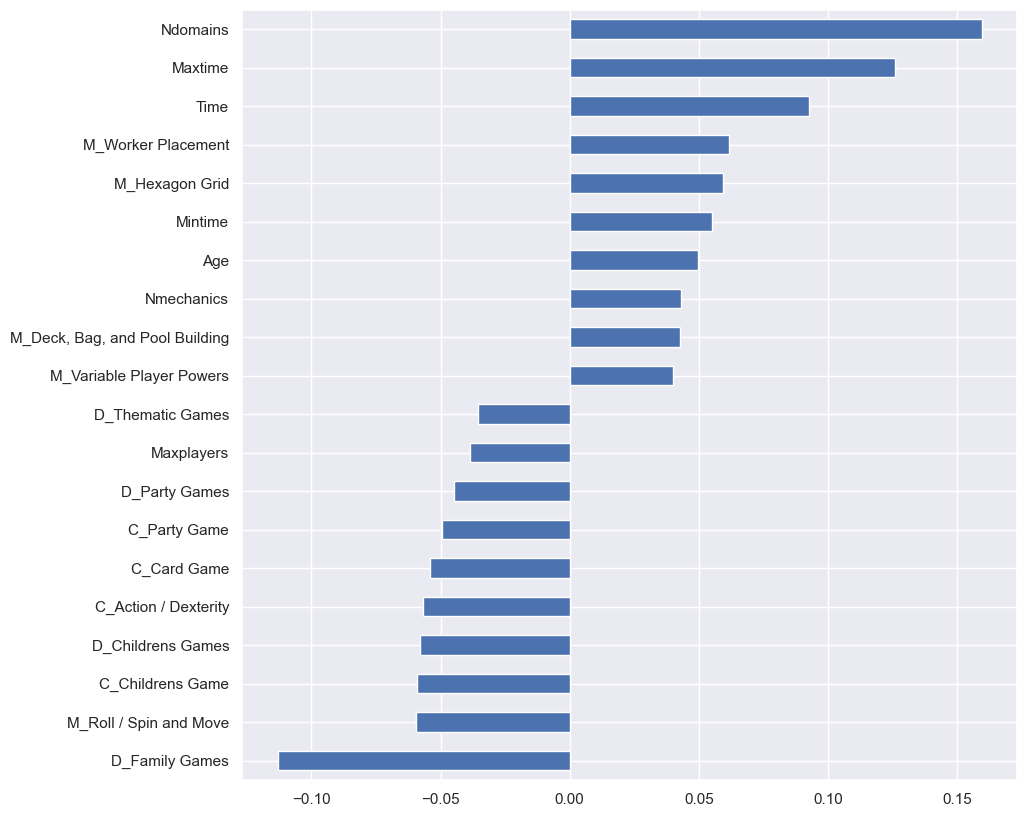

In [66]:
# check last model about Complexity
matplotlib.rcParams['font.family'] = 'sans-serif'
coef_ = pd.Series(ridge_model[1].best_estimator_['ridge'].coef_,
          index = ridge_model[1].best_estimator_['selectkbest'].get_feature_names_out()).sort_values()

pd.concat([coef_.head(10), coef_.tail(10)]).plot.barh(figsize=(10, 10))
plt.show()

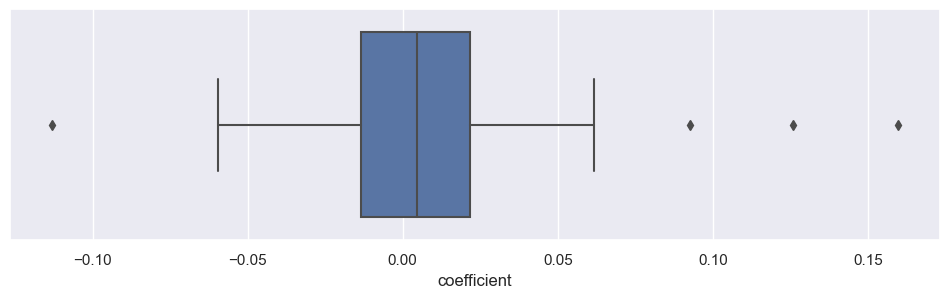

In [67]:
# simple linear에 비해 비교적 대칭적인 회귀계수
sns.set(rc={'figure.figsize':(12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()